In [1]:
from unsampled import *
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator

from scipy.stats.stats import pearsonr
import scipy.stats as stats

## Tree Visualizations

### Setting up the Trees and Plotting

In [2]:
t1 = Tree.get(path="tree1", schema="nexus")

In [3]:
rd.seed(100) #for replicability
pruned_dict = randomly_prune_tree(t1, .95)
popsize = 1

#matrix of observed and expected attachemt to each edge in the pruned tree for each dropped sample
exp = theoretical_attachment_prob_matrix(pruned_dict.get('full_tree'), pruned_dict.get('pruned_tree'), pruned_dict.get('root_reference'), 
                                   popsize, pruned_dict.get('node_root_dist_full_tree'), pruned_dict.get('dropped_samples'))
obs = observed_attachment_prob_matrix(pruned_dict.get('full_tree'), pruned_dict.get('pruned_tree'), pruned_dict.get('dropped_samples'))

#cumulative proportion of sampling expected under each clade
node_probs = calculate_cumulative_node_prob(t1, 1)

Give each sample a y-position for plotting (both for the full tree and the pruned, remaining tree)

In [4]:
#y-plotting for the full tree
y_positions = y_dist_dict(t1)

#y-plotting for the pruned tree
y_pos = y_dist_dict(pruned_dict.get('pruned_tree'))

In [5]:
#create the list of node labels that correspond to the pruned tree in the full tree
tips_left = [node for node in pruned_dict.get('pruned_tree').leaf_nodes()]
pruned_labs = [node.label for node in tips_left]
for sample in tips_left:
    curr = next(n for n in pruned_dict.get('full_tree').nodes() if n.label == sample.label)
    while curr.label != pruned_dict.get('pruned_tree').seed_node.label:
        pruned_labs.append(curr.label)
        curr = curr.parent_node
pruned_labs.append(pruned_dict.get('pruned_tree').seed_node.label)        
pruned_labs = list(set(pruned_labs))

#dictionary of the number of times each remaining edge has a missing branch
pruned_tree_labs = [node.label for node in pruned_dict.get('pruned_tree').nodes()]
true_num_unsamp = {}
obs = observed_attachment_prob_matrix(pruned_dict.get('full_tree'), pruned_dict.get('pruned_tree'), pruned_dict.get('dropped_samples'))
for nd_row in obs:
    obs_index = list(nd_row).index(1)
    if pruned_tree_labs[obs_index] in true_num_unsamp.keys():
        true_num_unsamp[pruned_tree_labs[obs_index]] += 1
    else:
        true_num_unsamp[pruned_tree_labs[obs_index]] = 1

In [6]:
#dictionary of the number of times each remaining edge has a missing branch
pruned_tree_labs = [node.label for node in pruned_dict.get('pruned_tree').nodes()]
true_num_unsamp = dict([(lab, 0) for lab in pruned_tree_labs])

obs = observed_attachment_prob_matrix(pruned_dict.get('full_tree'), pruned_dict.get('pruned_tree'), pruned_dict.get('dropped_samples'))
for nd_row in obs:
    obs_index = list(nd_row).index(1)
    true_num_unsamp[pruned_tree_labs[obs_index]] += 1

In [7]:
#color map shifting
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('Blues')
new_cmap = truncate_colormap(cmap, 0.2, 1.0)

In [8]:
#defaults across all plots
rt_len = .1
alpha_scale_factor = 87.1
y_ax = len(pruned_dict.get('pruned_tree').leaf_nodes())
#colors
cmap = mpl.cm.get_cmap(new_cmap) # blue color map for gradients
unsamp = '#67001f' 
samp = '#053061'

#default line type, point size, branch width
lty = '-'
s = 50
branchWidth=2.7

#font 
mpl.rcParams['font.serif'] = "Latin Modern Roman"
mpl.rcParams['font.family'] = "serif"

In [9]:
branch_expected = [] #aggregated 
branch_observed = []
diff_dist = [] #distribution of the differences between the expected and observed
for index, k in enumerate(pruned_dict.get('pruned_tree').nodes()):
    edge_prb = exp[:,index] #column from expected at the index of the current edge
    sum_exp = sum(edge_prb) #column sum/number of samples
    dropped = true_num_unsamp.get(k.label)
    branch_expected.append(sum_exp)
    branch_observed.append(dropped)
    diff_dist.append(sum_exp - dropped) #expected - observed 

### Full Tree with Missing Samples

In [ ]:
#plotted missing samples
fig,ax = plt.subplots(figsize=(45,30),facecolor='w')

for k in pruned_dict.get('full_tree').nodes(): # iterate over objects in full tree
    # positioning
    y=y_positions.get(k) 
    yp = y_positions.get(k.parent_node)
    if k.edge.rootedge:
        x=0.0
    else:
        x=k.distance_from_root()
    if k.parent_node==None:
        xp=x-rt_len #draw a root of length (arbitrary)
    else:
        xp=k.parent_node.distance_from_root()

    # dropped tips, color, lty, size
    c = [unsamp if k.label not in pruned_labs else samp][0]
    a = [.3 if k.label not in pruned_labs else 1][0]
    l = ['--' if k.label not in pruned_labs else '-'][0]
    sz = [30 if k.label not in pruned_labs else 50][0]
    
    if k.is_leaf(): # if leaf...
        ax.scatter(x,y,s=sz,facecolor=c,edgecolor=c,alpha = a, zorder=11) # plot circle for every tip
        #ax.scatter(x,y,s=sz+0.8*sz,facecolor='k',edgecolor='none', alpha = a, zorder=10) # plot black circle underneath
    ax.plot([xp,xp],[y, yp],lw=branchWidth, color=c,ls=l, alpha = a, zorder=9) #vertical bar plotting
    ax.plot([xp,x], [y,y], lw=branchWidth, color=c, ls=l, alpha = a, zorder=9) #branch plotting
       
ax.set_ylim(-15, len(pruned_dict.get('full_tree').leaf_nodes()) + 15)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
#fig.savefig('dropped-samps.png', bbox_inches = 'tight', transparent = True)
plt.show()

### Pruned Tree Labeled with Observed Missing Samples on Each Branch

In [ ]:
#plotted missing samples
fig,ax = plt.subplots(figsize=(30,20),facecolor='w')

for k in pruned_dict.get('pruned_tree').nodes(): # iterate over objects in tree
    
    # positioning
    y=y_pos.get(k) 

    if k.parent_node==None:
        x=0.0
        xp=x
        yp = y_pos.get(k)
    else:
        yp = y_pos.get(k.parent_node)
        xp=k.parent_node.distance_from_root()
        x=k.distance_from_root()
        
    #distribution of missing samples
    if true_num_unsamp.has_key(k.label):
        dropped = true_num_unsamp.get(k.label)
    else:
        dropped = 0

    if k.is_leaf(): # if leaf...
        ax.scatter(x,y,s=s,facecolor=samp,edgecolor=samp,zorder=11) # plot circle for every tip
        ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) # plot black circle underneath
        
    ax.plot([xp,xp],[y, yp],lw=branchWidth, color=samp,ls=lty,zorder=9) #vertical bar plotting
    ax.plot([xp,x], [y,y], lw=branchWidth, color=samp, ls=lty, zorder=9) #branch plotting
    
    #labeling number of true missing branches along each edge
    ax.text(x-.5*(x-xp) , y, dropped, va='bottom', ha='center', size=12, color = samp) 
       
ax.set_ylim(-5, y_ax + 5)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

#fig.savefig('pruned-tree.png', bbox_inches = 'tight', transparent = True)
plt.show()

### Pruned Tree with Distribution of Expected and Observed Missing Samples

Plots the pruned tree with the distribution of emperically observed and expected missing sampled. The opacity of the rectangle above each branch represents the raw number of expected observations predicted by the algorithm (expected proportion multiplied by the number of missing samples). The opacity of the rectangle below each branch represents the actual number of samples missing from that branch. When the difference between the observed and expected differs by more than 1% of the total dropped branches, the actual counts of predicted and observed are labeled by the respective rectangle.

In [ ]:
#plotted missing samples distribution
fig,ax = plt.subplots(figsize=(55, 35), facecolor='w')

for index, k in enumerate(pruned_dict.get('pruned_tree').nodes()): ## iterate over objects in tree
    #distribution of missing samples
    if true_num_unsamp.has_key(k.label):
        dropped = true_num_unsamp.get(k.label)
    else:
        dropped = 0
    
    # positioning
    y=y_pos.get(k) 

    if k.parent_node==None:
        x=0.0
        xp=x
        yp = y_pos.get(k)
    else:
        yp = y_pos.get(k.parent_node)
        xp=k.parent_node.distance_from_root()
        x=k.distance_from_root()
    
    if k.is_leaf(): # if leaf...
        ax.scatter(x,y,s=s,facecolor=samp,edgecolor=samp,zorder=11) # plot circle for every tip
        ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) # plot black circle underneath
    ax.plot([xp,xp],[y, yp],lw=branchWidth, color=samp,ls=lty,zorder=9) #vertical bar plotting
    ax.plot([xp,x], [y,y], lw=branchWidth, color=samp, ls=lty, zorder=9) #branch plotting
    
    #expected distribution of missing data
    edge_prb = exp[:,index]
    alph = sum(edge_prb) #raw column sum
    ax.add_patch(mpl.patches.Rectangle((xp,y), (x-xp), .3, color = unsamp, alpha = alph/alpha_scale_factor)) #predicted proportion of dropped
    ax.add_patch(mpl.patches.Rectangle((xp,y-.3), (x-xp), .3, color = unsamp, alpha = int(dropped)/alpha_scale_factor)) #actual dropped

    #labeling
    #if abs(int(dropped) - alph) > .01*len(pruned_dict.get('dropped_samples')): #greater than 1% misclassification ~15 samps
    ax.text(x-1.0/2*(x-xp) , y-.4, dropped, va='top', ha='center', size=15, color = unsamp) #actual dropped
    ax.text(x-1.0/2*(x-xp) , y+.4, str(round(alph,1)), va='bottom', ha='center', size=15, color = unsamp) #predicted dropped
ax.set_ylim(-5, y_ax + 5)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

plt.show()

### Pruned Tree with Expected and Observed Missing Samples (Branch Widths and Tick Marks)

The weight of the branch corresponds to the number of expected missing samples along the branch (aggregated from the expected matrix for each branch). The number of tick marks corresponds to the actual number of observed dropped samples along that branch. Each 5 dropped samples have a full tick mark and a fraction of a tick mark represents a remainder

In [ ]:
#plotted missing samples
fig,ax = plt.subplots(figsize=(30,20),facecolor='w')

for index, k in enumerate(pruned_dict.get('pruned_tree').nodes()): ## iterate over objects in tree
    
    # positioning
    y=y_pos.get(k) 

    if k.parent_node==None:
        x=0.0
        xp=x-.1
        yp = y_pos.get(k)
    else:
        yp = y_pos.get(k.parent_node)
        xp=k.parent_node.distance_from_root()
        x=k.distance_from_root()
    
    if k.is_leaf(): # if leaf...
        ax.scatter(x,y,s=s,facecolor=samp,edgecolor=samp,zorder=11) # plot circle for every tip
        ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) # plot black circle underneath
    ax.plot([xp,xp],[y, yp],lw=1, color=samp,ls=lty,zorder=9) #vertical bar plotting
    ax.plot([xp,x], [y,y], lw=branch_expected[index]*.1, color=samp, ls=lty, zorder=9) #branch plotting -width
    #ax.plot([xp,x], [y,y], lw=branchWidth, color=cmap(branch_expected[index]/53.9), ls=lty, zorder=9)
    
    #variables for plotting the tick marks
    dropped = branch_observed[index]
    full_ticks = int(dropped/5.0)
    remainder_ticks = dropped % 5
    tick_x_pos = []
    spacing = .007
    ttl_tick_height = 1.0
    
    if dropped == 0: #no oserved samples here, dont do anything
        pass
        #ax.text(x - .5*(x-xp), y-.5, dropped, va = 'center', ha= 'center', size=12, color = unsamp, weight ='bold')
    elif full_ticks == 0: #only a remainder
        h = remainder_ticks/5.0*ttl_tick_height
        plt.plot([x - .5*(x-xp),x - .5*(x-xp)], [y-h/2.0,y+h/2.0], c = unsamp, ls = "-", zorder = 15)
        #ax.text(x - .5*(x-xp), y-.5, dropped, va = 'top', ha= 'center', size=12, color = unsamp, weight ='bold')
    else: #plot ticks and any remainders
        start_x = (x - .5*(x-xp)) - (int(full_ticks/2)+1)*spacing
        while len(tick_x_pos) < full_ticks:
            tick_x_pos.append(start_x)
            start_x += spacing
        for curr_tick in tick_x_pos:
            plt.plot([curr_tick,curr_tick], [y-ttl_tick_height/2.0,y+ttl_tick_height/2.0], c = unsamp, ls = "-", zorder = 15)
        h = remainder_ticks/5.0*ttl_tick_height
        plt.plot([tick_x_pos[-1]+spacing,tick_x_pos[-1]+spacing], [y-h/2.0,y+h/2.0], c = unsamp, ls = "-", zorder = 15)
    #text giving the acutal number observed and expected on each branch
    #ax.text(x - .5*(x-xp), y-.8, dropped, va = 'top', ha= 'center', size=12, color = unsamp, weight ='bold')
    #ax.text(x-.5*(x-xp) , y+.5, round(branch_expected[index], 1), va='bottom', ha='center', size=12, color = unsamp) 
ax.set_ylim(-5, len(pruned_dict.get('pruned_tree').leaf_nodes()) + 5)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
#fig.savefig('obs-exp.png', bbox_inches = 'tight', transparent = True)
plt.show()

### Plotting Branch Area as a Function of Expected Probability of Attachment to Branch

The branch length is predetermined, but the branch area is determined by the scaled averaged expectation for attachment to a specific branch. Thus, the height of the branch represents the expected amount of attachment/unit of branch length. The label corresponds to the raw difference between observed and expected attachments to a branch (expectation - observations). The color corresponds to the percentile the difference falls under (much greater number of observations than expected is darker red).

In [10]:
np.percentile(diff_dist, 50) #white should be at 1.9, the 50th percentile

1.925885713099615

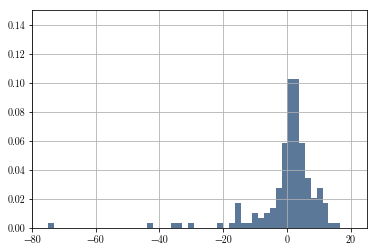

In [11]:
x = diff_dist
# the histogram of the data
n, bins, patches = plt.hist(x, 50, normed=1, facecolor=samp, alpha=0.65)

plt.axis([-80, 25, 0, 0.15])
plt.grid(True)
plt.show()

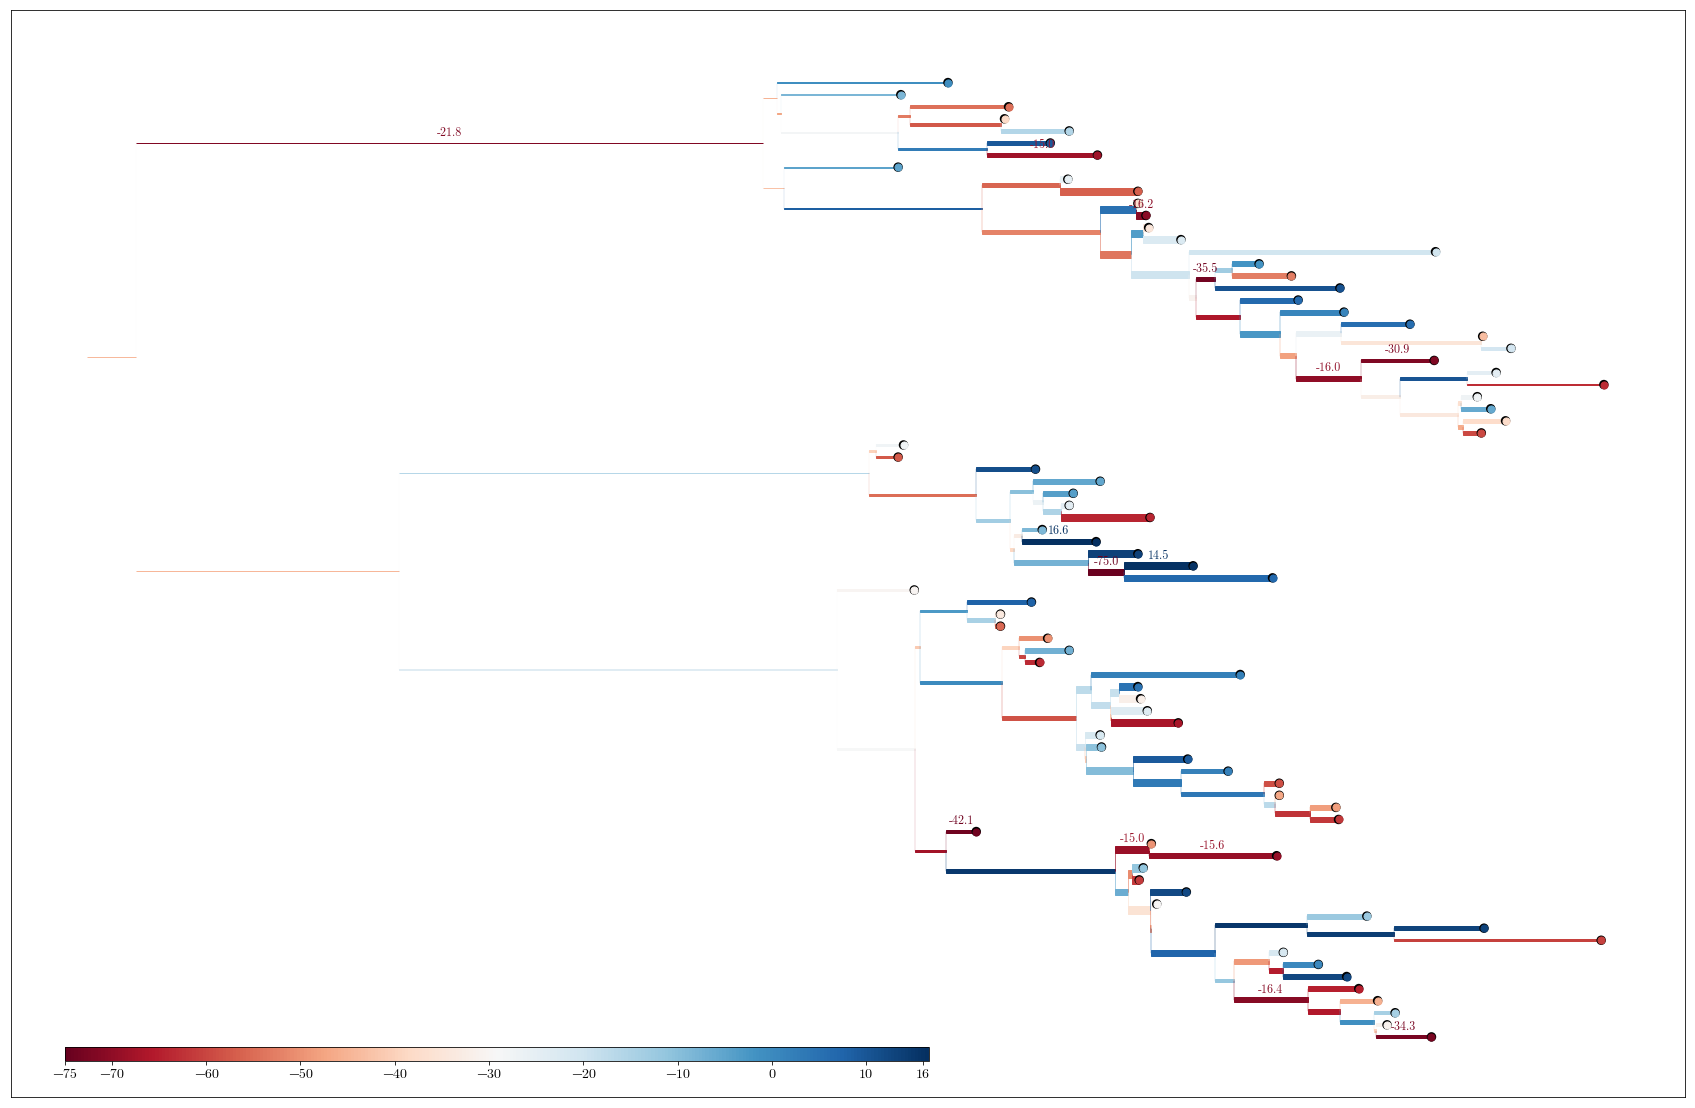

In [38]:
#plotted missing samples distribution
fig,ax = plt.subplots(figsize=(30, 20), facecolor='w')
for index, k in enumerate(pruned_dict.get('pruned_tree').nodes()): ## iterate over objects in tree
    # positioning
    y=y_pos.get(k) 

    if k.parent_node==None:
        x=0.0
        xp=-.1
        yp = y
    else:
        yp = y_pos.get(k.parent_node)
        xp=k.parent_node.distance_from_root()
        x=k.distance_from_root()
        
    #distribution of missing samples
    if true_num_unsamp.has_key(k.label):
        dropped = true_num_unsamp.get(k.label)
    else:
        dropped = 0
        
    #expected distribution of missing data
    edge_prb = exp[:,index] #column from expected at the index of the current edge
    avg_exp = sum(edge_prb)/len(edge_prb) #column sum/number of samples
    rec_area = avg_exp*5.0 #scale factor
    leng = x-xp
    heig = rec_area/(leng + .000001)

    #color heatmapping
    cmap2 = mpl.cm.get_cmap('RdBu')
    percentile = stats.percentileofscore(diff_dist, sum(edge_prb)-dropped)/100.0
        
    if k.is_leaf(): # if leaf...
        ax.scatter(x,y,s=s,facecolor=cmap2(percentile), edgecolor=cmap2(percentile), zorder=11) # plot circle for every tip
        ax.scatter(x,y,s=s+0.8*s,facecolor='k', edgecolor='none', zorder=10) # plot black circle underneath
    ax.plot([xp,xp],[y, yp],lw=heig, color=cmap2(percentile),ls=lty,zorder=9) #vertical bar plotting
    ax.add_patch(mpl.patches.Rectangle((xp,y-.5*heig), (x-xp), heig, color = cmap2(percentile))) #predicted proportion of dropped
    
    #labeling - raw difference between observed and expected (expected - observed),
    if abs(avg_exp*len(edge_prb)-dropped) > 14:
        ax.text(x-1.0/2*(x-xp) , y+.4, str(round(avg_exp*len(edge_prb),1)-dropped), va='bottom', ha='center', size=12, color = cmap2(percentile), zorder = 20)

#axis parameters
ax.set_ylim(-5, y_ax + 5)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

#colorbar parameters
ax1 = fig.add_axes([.15, .15, .4, 0.01], frameon = False)
norm = mpl.colors.Normalize(vmin=min(diff_dist), vmax=max(diff_dist)) #normalize to fit range of differences (instead of 0 to 1)
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap2, norm = norm, orientation='horizontal', ticks = [int(min(diff_dist)), -70, -60, -50, -40, -30, -20, -10, 0, 10, int(max(diff_dist))])
cb1.ax.tick_params(labelsize=14) #increase font size

#fig.savefig('rate-diff.png', bbox_inches = 'tight', transparent = True)
plt.show()

In [29]:
max(diff_dist)

16.632738828920406

### Proportion of Tips Expected Under Each Internal Node - Remaining Tree

Plots the cumulative proportion of samples expected under each clade and a corresponding color is mapped to this proportion. Darker colors indicate a greater proportion of data expected to fall under that clade. Only internal nodes with greater than .01 proportion of the data are labeled with their respective proportion.

In [ ]:
node_probs2 = calculate_cumulative_node_prob(pruned_dict.get('pruned_tree'), 1)

In [ ]:
fig,ax = plt.subplots(figsize=(30,20),facecolor='w')

for k in pruned_dict.get('pruned_tree').nodes(): ## iterate over objects in tree
    
    # positioning
    y=y_pos.get(k) 
    if k.edge.rootedge:
        x=0.0
    else:
        x=k.distance_from_root()
    
    txt = ""
    # dropped tips, color, lty, size
    if node_probs2.get(k) != None:
        c = cmap((node_probs2.get(k)))
        if node_probs2.get(k) >= .01: #only show the label if its greater than 1% expected prop data
            txt = round(node_probs2.get(k), 2)
    else:
        c = cmap((node_probs2.get(k.parent_node)))

    if k.is_leaf(): # if leaf...
        ax.scatter(x,y,s=s,facecolor=c,edgecolor=c,zorder=11) # plot circle for every tip
        ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) # plot black circle underneath
        
    else:
        yc1 = y_pos.get(k.child_nodes()[0])
        yc2 = y_pos.get(k.child_nodes()[-1])
        xc1 = k.child_nodes()[0].distance_from_root()
        xc2 = k.child_nodes()[-1].distance_from_root()
    
        ax.plot([x,x],[yc1, yc2],lw=branchWidth, color=c,ls=lty,zorder=9) #vertical bar plotting
        ax.plot([xc1,x], [yc1,yc1], lw=branchWidth, color=c, ls=lty, zorder=9) #plot top child edge
        ax.plot([xc2,x], [yc2,yc2], lw=branchWidth, color=c, ls=lty, zorder=9) #plot bottom child edge
    
    #labeling
    ax.text(x + .009, y, txt, va = 'center', ha= 'left', size=12, color = 'k', weight ='bold')

ax.set_ylim(-5, y_ax + 5)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
#fig.savefig('cumulative-clade-prop.png', bbox_inches = 'tight', transparent = True)
plt.show()

### Visualizing the Tree at a Cutpoint (How a Specific Dropped Sample is Attaching)

In [ ]:
samp_dist = pruned_dict.get('node_root_dist_full_tree').get(pruned_dict.get('dropped_samples')[0])
partial_pcoal = pcoal_along_edge(tree=pruned_dict.get('pruned_tree'), popsize = 1, cut_dist_from_root = samp_dist)


In [ ]:
pruned_dict.get('dropped_samples')[0]

In [ ]:
fig,ax = plt.subplots(figsize=(30,20),facecolor='w')

for k in pruned_dict.get('pruned_tree').nodes(): ## iterate over objects in tree
    # positioning
    y=y_pos.get(k) 

    if k.parent_node==None:
        x=0.0
        xp=x-.1
        yp = y_pos.get(k)
    else:
        yp = y_pos.get(k.parent_node)
        xp=k.parent_node.distance_from_root()
        x=k.distance_from_root()
    txt = ''  
    if partial_pcoal.get(k.edge) != None:
        c = cmap(partial_pcoal.get(k.edge)/.0862)
        txt = round(partial_pcoal.get(k.edge)*100.0, 2)
    else:
        c = cmap(partial_pcoal.get(k.parent_node.edge)/.09)
 
    if x > samp_dist and xp > samp_dist:
        if k.is_leaf(): # if leaf...
            ax.scatter(x,y,s=s,facecolor='lightgrey',edgecolor='lightgrey',zorder=11) # plot circle for every tip
            ax.scatter(x,y,s=s+0.8*s,facecolor='darkgrey',edgecolor='none',zorder=10) # plot black circle underneath
        ax.plot([xp,xp],[y, yp],lw=branchWidth, color='lightgrey',ls=lty,zorder=9) #vertical bar plotting
        ax.plot([xp,x], [y,y], lw=branchWidth, color='lightgrey', ls=lty, zorder=9) #branch plotting
    elif x < samp_dist and xp < samp_dist:
        if k.is_leaf(): # if leaf...
            ax.scatter(x,y,s=s,facecolor=c,edgecolor=c,zorder=11) # plot circle for every tip
            ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) # plot black circle underneath
        ax.plot([xp,xp],[y, yp],lw=branchWidth, color=c,ls=lty,zorder=9) #vertical bar plotting
        ax.plot([xp,x], [y,y], lw=branchWidth, color=c, ls=lty, zorder=9) #branch plotting
    else:
        if k.is_leaf(): # if leaf...
            ax.scatter(x,y,s=s,facecolor='lightgrey',edgecolor='lightgrey',zorder=11) # plot circle for every tip
            ax.scatter(x,y,s=s+0.8*s,facecolor='darkgrey',edgecolor='none',zorder=10) # plot black circle underneath
        ax.plot([xp,xp],[y, yp],lw=branchWidth, color=c,ls=lty,zorder=9) #vertical bar plotting
        ax.plot([samp_dist,x], [y,y], lw=branchWidth, color='lightgrey', ls=lty, zorder=9) #branch plotting
        ax.plot([xp,samp_dist], [y,y], lw=branchWidth, color=c, ls=lty, zorder=9) #branch plotting
    
    #labeling
    if txt > .5: #text is already in percentages (this means the new sample has at least a .5% chance of attaching at the specified edge)
        ax.text(x-.5*(x-xp) + .009, y, txt, va = 'bottom', ha= 'center', size=14, color = 'k', zorder=20)

plt.axvline(samp_dist, c = "lightgrey")   

ax.set_ylim(-5, y_ax + 5)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)


#fig.savefig('time-slice.png', bbox_inches = 'tight', transparent = True)
plt.show()

In [ ]:
edge_pcoal = pcoal_along_edge(tree=pruned_dict.get('pruned_tree'), popsize = 1)
scale_fctr=.09

In [ ]:
fig,ax = plt.subplots(figsize=(30,20),facecolor='w')

for k in pruned_dict.get('pruned_tree').nodes(): ## iterate over objects in tree
    # positioning
    y=y_pos.get(k) 

    if k.parent_node==None:
        x=0.0
        xp=x-.1
        yp = y_pos.get(k)
    else:
        yp = y_pos.get(k.parent_node)
        xp=k.parent_node.distance_from_root()
        x=k.distance_from_root()
    txt = ''  
    if edge_pcoal.get(k.edge) != None:
        c = cmap(edge_pcoal.get(k.edge)/scale_fctr)
        txt = round(edge_pcoal.get(k.edge)*100.0, 2)
    else:
        c = cmap(edge_pcoal.get(k.parent_node.edge)/scale_fctr)
 

    if k.is_leaf(): # if leaf...
        ax.scatter(x,y,s=s,facecolor=c,edgecolor=c,zorder=11) # plot circle for every tip
        ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) # plot black circle underneath
    ax.plot([xp,xp],[y, yp],lw=branchWidth, color=c,ls=lty,zorder=9) #vertical bar plotting
    ax.plot([xp,x], [y,y], lw=branchWidth, color=c, ls=lty, zorder=9) #branch plotting
   
    #labeling
    if txt > .5: #text is already in percentages (this means the new sample has at least a .5% chance of attaching at the specified edge)
        ax.text(x-.5*(x-xp) + .009, y, txt, va = 'bottom', ha= 'center', size=14, color = 'k', zorder=20)

ax.set_ylim(-5, y_ax + 5)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)


#fig.savefig('edge-prb.png', bbox_inches = 'tight', transparent = True)
plt.show()

### Z-Scores of Pruned Tree

In [ ]:
zs2 = node_zscores(node_probs2, pruned_dict.get('pruned_tree'))

In [ ]:
fig,ax = plt.subplots(figsize=(30,20),facecolor='w')
cmap2 = mpl.cm.get_cmap('RdBu')

for k in pruned_dict.get('pruned_tree').nodes(): ## iterate over objects in tree
    plot_lab = False
    # positioning
    y=y_pos.get(k) 
    if k.edge.rootedge:
        x=0.0
    else:
        x=k.distance_from_root()

    # tree color, label color
    if node_probs2.get(k) != None:
        c = cmap2(1-((zs2.get(k)+1.18)/3.51))
        txt = round(zs2.get(k), 2)
        if abs(round(zs2.get(k), 2)) >= 1.0:
            plot_lab = True
        
        if zs2.get(k) > 0:
            txt_c = "k"
        else:
            txt_c = 'grey'
    else:
        c = cmap2(1-((zs2.get(k.parent_node)+1.18)/3.51))
        txt = ""
        
    #plotting
    if k.is_leaf(): # if leaf...
        ax.scatter(x,y,s=s,facecolor=c,edgecolor=c,zorder=11) # plot circle for every tip
        ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) # plot black circle underneath
        
    else:
        yc1 = y_pos.get(k.child_nodes()[0])
        yc2 = y_pos.get(k.child_nodes()[-1])
        xc1 = k.child_nodes()[0].distance_from_root()
        xc2 = k.child_nodes()[-1].distance_from_root()
    
        ax.plot([x,x],[yc1, yc2],lw=branchWidth, color=c,ls=lty,zorder=9) #vertical bar plotting
        ax.plot([xc1,x], [yc1,yc1], lw=branchWidth, color=c, ls=lty, zorder=9) #plot top child edge
        ax.plot([xc2,x], [yc2,yc2], lw=branchWidth, color=c, ls=lty, zorder=9) #plot bottom child edge
    
    #labeling
    if plot_lab:
        ax.text(x + .007, y, txt, va = 'center', ha= 'left', size=12, color = c)

ax.set_ylim(-5, y_ax + 5)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

#fig.savefig('z-scores.png', bbox_inches = 'tight', transparent = True)
plt.show()